In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [2]:
def get_sigma(x):
    """
    Parameters
    ----------
    x : list
        x is a list of g_band apparent magnitude

    Returns
    -------
    sigma : np.array
        sigma is a numpy array of adjusted gaia photometric uncertainty of corresponding g_band apparent magnitude

    """
    sigma =[]
    for n in range(len(x)):
        if x[n] <13:
            precision = 10*(10**(-3))
        elif x[n] < 18:
            precision = 16*(10**(-3))
        else:
            precision = 100*(10**(-3))
        #error propagation for sigma
        sigma.append(np.sqrt(2*precision**2))
    sigma = np.array(sigma)
    return sigma

In [3]:

def rejection(x_s1, y_s1, outliers_5sigma, y_5sigma):
    """

    Parameters
    ----------
    x_s1 : list
        segment of g_band apparent magnitude
    y_s1 : list
        segment of bp-rp band apparent magnitude corresponding to the g_band magnitude
    outliers_5sigma : list
        a list of g_band apparent magnitude that is rejected with a bp-rp deviation above 5 sigma level
    y_5sigma : list
        a list of bp-rp apparent magnitude that is rejected with a deviation above 5 sigma level

    Returns
    -------
    x_s1 : list
        segment of "good points'" g_band apparent magnitude
    y_s1 : list
        segment of "good points'" bp-rp apparent magnitude corresponding to gmag
    outliers_5sigma : list
        a list of g_band magnitude corresponding to rejected stars
    y_5sigma : list
        a list of bp-rp magnitude corresponding to rejected stars
    model : 1-D spline object
        a spline model object fitted from x_s1 and y_s1

    """
    # get the difference between the values predicted by the model and the actual bp-rp values
    for j in range(20):
        #diff is a list of difference
        diff = []
        #initialize a spline model from x_s1 and y_s1
        model = UnivariateSpline(x_s1, y_s1, k=4)
        #generate a list of predicted bp-rp band corresponding to x_s1
        predicted = model(x_s1)
        # get the difference between the values predicted by the model and the actual bp-rp values
        diff = y_s1 - predicted

        #get the photometric uncertainties of stars with the g_mag
        sigma = get_sigma(x_s1)
        #generate lists of "good points"
        x_filtered = []
        y_filtered = []
        #reject significant outliers before fittings that perform 5 sigma rejection
        if j == 0:
            for k in range(len(diff)):
                if np.abs(diff[k]) >= 10*sigma[k]:
                    outliers_5sigma.append(x_s1[k])
                    y_5sigma.append(y_s1[k])

                else:
                    x_filtered.append(x_s1[k])
                    y_filtered.append(y_s1[k])
            x_s1 = x_filtered
            y_s1 = y_filtered
        #perform 5 sigma rejection
        else:
            for k in range(len(diff)):
                if np.abs(diff[k]) >= 5*sigma[k]:
                    outliers_5sigma.append(x_s1[k])
                    y_5sigma.append(y_s1[k])
                else:
                    x_filtered.append(x_s1[k])
                    y_filtered.append(y_s1[k])
            x_s1 = x_filtered
            y_s1 = y_filtered
        
    return x_s1, y_s1,outliers_5sigma, y_5sigma, model


In [4]:
def segments(df_cluster):
    """
    
    Parameters
    ----------
    df_cluster : panda dataframe
        panda dataframe of stars in a cluster with sorted g_mag

    Returns
    -------
    x_s1 : list
        a list of g_mag segments with g_mag<13
    y_s1 : list
        a list of bp-rp segments corresponding to g_mag<13
    x_s2 : list
        a list of g_mag segments with g_mag>13
    y_s2 : TYPE
        a list of bp-rp segments corresponding to g_mag>13
    x_non_ms : list
        a list of g_mag segments of non-main-sequence stars
    y_non_ms : list
        a list of bp-rp_mag segments of non-main-sequence stars

    """
    #generate lists of segments
    x_s1=[]
    y_s1=[]
    x_s2=[]
    y_s2=[]
    x_non_ms=[]
    y_non_ms=[]
    #x is the g_mag of stars in a cluster
    x = np.array(df_cluster['gmag'])
    #y is the bp-rp mag of stars in a cluster
    y = np.array(df_cluster['bpmag']- df_cluster['rpmag'])
    #get the g_mag of the turnoff point
    x_turn = turnoff(x,y)
    #function needed to exclude non main sequence
    for i in range(len(x)):
        # append g_mag and bp-rp mag to their corresponding segments.
        if (x[i]<=13 and x[i] >= x_turn):
            x_s1.append(x[i])
            y_s1.append(y[i])
        elif(x[i]>13):
            x_s2.append(x[i])
            y_s2.append(y[i])
        elif(x[i]<x_turn):
            x_non_ms.append(x[i])
            y_non_ms.append(y[i])
    return x_s1, y_s1, x_s2, y_s2, x_non_ms, y_non_ms

In [5]:
def turnoff(x,y):
    """
    

    Parameters
    ----------
    x : list
        g_mag apparent magnitude of stars
    y : list
        bp-rp apparent mag of stars.

    Returns
    -------
    x_turn : float
        the g_band mag of the turnoff point.

    """
    #get copies of g_mag and bp-rp mag
    x_copy = x
    y_copy = y
    #lists of significant outliers
    x_rej=[]
    y_rej=[]
    #lists of filtered stars
    x_filtered = []
    y_filtered = []
    #assume the turnoff is the g_mag of the brightest star
    x_turn = x_copy[0]
    #iterate twice: the first iteration rejects significant outliers; the second iteration fits the model and finds the turnoff,
    for j in range(2):
        #get the difference between fitted model and the observed bp-rp
        diff = []
        model = UnivariateSpline(x_copy, y_copy, k=4)
        predicted = model(x_copy)

        # get the difference between the values predicted by the model and the actual bp-rp values
        diff = y_copy - predicted

        #get the photometric uncertainties of stars with the g_mag
        sigma = get_sigma(x_copy)
        #critical points are those whose derivatives vanish
        x_critical = model.derivative().roots()
        for i in range(len(x_critical)):
            #find the point whose second derivative is positive
            if model.derivatives(x_critical[i])[2]>0:
                x_turn = x_critical[i]
        #reject significant outliers in the first iteration
        if(j == 0):
            for k in range(len(diff)):
                if np.abs(diff[k]) < 20*sigma[k] or x_copy[k] <= x_turn: #and 13<= x_s1[k]< 18:
                    x_filtered.append(x_copy[k])
                    y_filtered.append(y_copy[k])
                elif diff[k] >= 20*sigma[k] and x_copy[k] > x_turn:
                    x_rej.append(x_copy[k])
                    y_rej.append(y_copy[k])
        x_copy = x_filtered
        y_copy = y_filtered
    return x_turn

In [6]:
#edit here to change the directory of the fit file
with fits.open('./open_cluster/NearbyClustersGaia_GALEX_SDSS_Skymapper_2MASS_WISE_ASASSN.fits') as hdu:
    asn_table = Table(hdu[1].data)
# convert fit to pd.dataframe
df = asn_table.to_pandas()
#edit here to change the name of the cluster
df_cluster = df[(df['Cluster']=='alphaPer')]
df_cluster.dropna(subset = ['gmag','rpmag','bpmag'], inplace = True)
#sort the dataframe
df_cluster.sort_values(by=['gmag'], inplace=True)

<ipython-input-6-24ab0e32fb69>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster.dropna(subset = ['gmag','rpmag','bpmag'], inplace = True)
<ipython-input-6-24ab0e32fb69>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster.sort_values(by=['gmag'], inplace=True)


In [7]:
'''get the segments; x_s1 is a list of g_mag segments with g_mag<13, y_s1 is a list of bp-rp segments corresponding to g_mag<13;
x_s2 is a list of g_mag segments with g_mag>13; y_s2 is a list of bp-rp segments corresponding to g_mag>13;
x_non_ms is a list of g_mag segments of non-main-sequence stars; y_non_ms is a list of bp-rp_mag segments of non-main-sequence stars'''
x_s1, y_s1, x_s2, y_s2, x_non_ms, y_non_ms = segments(df_cluster)

In [9]:
outliers_5sigma=[]
y_5sigma = []
#perform iterative spline rejections
x_s1, y_s1, outliers_5sigma, y_5sigma, model = rejection(x_s1, y_s1, outliers_5sigma, y_5sigma)
x_s2, y_s2, outliers_5sigma, y_5sigma,model1 = rejection(x_s2, y_s2, outliers_5sigma, y_5sigma)

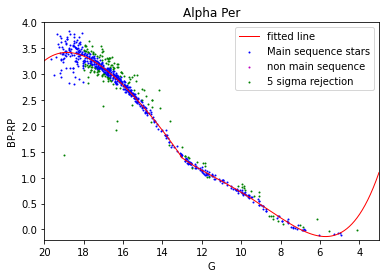

In [12]:
# plot the good values alongside the rejected values and the fitted line
#edit here to adapt to the range of the plot
plt.xlim(20,3)
plt.ylim(-0.2,4)
#edit here to adapt to the range of the fitted line
#model is the univariate model for g_mag <13, model1 is the univariate model for g_mag>13.
xs = np.linspace(3, 13, 1000)
xs1 = np.linspace(13,20,1000)
plt.plot(xs, model(xs), 'r', label = 'fitted line',lw=1)
plt.plot(xs1, model1(xs1), 'r', lw=1)
plt.scatter(x_s2, y_s2, c = 'b', label = 'Main sequence stars', s = 1)
plt.scatter(x_s1, y_s1, c = 'b', s = 1)
plt.scatter(x_non_ms, y_non_ms , c = 'm', label = 'non main sequence', s = 1)
plt.scatter(outliers_5sigma, y_5sigma, c = 'g', label = '5 sigma rejection', s=1)
plt.xlabel('G')
plt.ylabel('BP-RP')

#plt.plot(x_lin_reg1, y_lin_reg1, c = 'r', label='Fitted line1')
plt.title('Alpha Per')
plt.legend()
plt.show()

In [ ]:
#get the total filtered g_mag and bp-rp mag
x_filtered = x_s1+x_s2
y_filtered = y_s1+y_s2

#generate Dataframe of photometric data of filtered stars
DF = df_cluster[df_cluster['gmag']==x_filtered[0]]
for i in range(1, len(x_filtered)):
    df2 = df_cluster[df_cluster['gmag']==x_filtered[i]]
    DF = DF.append(df2, ignore_index=True)
#output csv
#Edit here for csv name
DF.to_csv('alphaPer.csv', index=False)